In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import pandas as pd

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_folder = "/content/drive/My Drive/drawings/spiral/training"
test_folder  = "/content/drive/My Drive/drawings/spiral/testing"

In [ ]:
# Function to load images from a folder structure
def load_images_from_folder(folder, target_size=(224,224)):
    images = []
    labels = []
    # Loop over each class folder (assumes subfolders per class)
    for label, class_folder in enumerate(sorted(os.listdir(folder))):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                # Process only image files
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    img = cv2.imread(img_path)
                    # Convert BGR to RGB
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    # Resize to 224x224 for ResNet50
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
# Load training and testing images
x_train, y_train = load_images_from_folder(train_folder, target_size=(224,224))
x_test, y_test   = load_images_from_folder(test_folder, target_size=(224,224))

In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (72, 224, 224, 3)
x_test shape: (30, 224, 224, 3)


In [ ]:
# Define augmentation generators (same for train and test here)
train_data_generator = ImageDataGenerator(rotation_range=360,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True)

test_data_generator = ImageDataGenerator(rotation_range=360,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True)

In [ ]:
# Augment training data: for each image, generate additional samples
x_aug_train = []
y_aug_train = []
num_aug_per_image = 5  # Number of augmentations per training image

In [ ]:
for i, img in enumerate(x_train):
    img_array = np.expand_dims(img, axis=0)
    aug_iter = train_data_generator.flow(img_array, batch_size=1, shuffle=True)
    for j in range(num_aug_per_image):
        aug_img = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_img)
        y_aug_train.append(y_train[i])

In [ ]:
# Combine original and augmented training data
x_train_aug = np.concatenate((x_train, np.array(x_aug_train)), axis=0)
y_train_aug = np.concatenate((y_train, np.array(y_aug_train)), axis=0)


In [ ]:
# Similarly augment testing data (use fewer augmentations)
x_aug_test = []
y_aug_test = []
num_aug_per_test = 2  # Number of augmentations per test image

In [ ]:
for i, img in enumerate(x_test):
    img_array = np.expand_dims(img, axis=0)
    aug_iter = test_data_generator.flow(img_array, batch_size=1, shuffle=True)
    for j in range(num_aug_per_test):
        aug_img = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_img)
        y_aug_test.append(y_test[i])

In [ ]:

# Combine original and augmented test data
x_test_aug = np.concatenate((x_test, np.array(x_aug_test)), axis=0)
y_test_aug = np.concatenate((y_test, np.array(y_aug_test)), axis=0)

print("Total training images after augmentation:", x_train_aug.shape[0])
print("Total testing images after augmentation:", x_test_aug.shape[0])

Total training images after augmentation: 432
Total testing images after augmentation: 90


In [ ]:
# Convert images to float32 and apply ResNet50 preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input
x_train_aug = preprocess_input(x_train_aug.astype('float32'))
x_test_aug  = preprocess_input(x_test_aug.astype('float32'))

In [ ]:
# Encode labels to 0/1 and then convert to one-hot encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc  = le.transform(y_test_aug)

In [ ]:
y_train_cat = to_categorical(y_train_enc)
y_test_cat  = to_categorical(y_test_enc)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Create a Sequential model
resnet_model = Sequential()

In [ ]:
# Load the pre-trained ResNet50 (without the top layer)
pretrained_model = ResNet50(include_top=False,
                            input_shape=(224,224,3),
                            pooling='avg',
                            weights='imagenet')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

In [ ]:
# Add the pre-trained model and custom layers
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))  # Two classes: healthy and parkinson

In [ ]:
# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Model Training
history = resnet_model.fit(x_train_aug, y_train_cat,
                           batch_size=32,
                           epochs=25,
                           validation_data=(x_test_aug, y_test_cat))

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5358 - loss: 0.7611 - val_accuracy: 0.5778 - val_loss: 0.7239
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6655 - loss: 0.6277 - val_accuracy: 0.6556 - val_loss: 0.6548
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7031 - loss: 0.5676 - val_accuracy: 0.7333 - val_loss: 0.6003
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7053 - loss: 0.5551 - val_accuracy: 0.7556 - val_loss: 0.5656
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7761 - loss: 0.4927 - val_accuracy: 0.7667 - val_loss: 0.5469
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7900 - loss: 0.4758 - val_accuracy: 0.7667 - val_loss: 0.5342
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8073 - loss: 0.4288 - val_accuracy: 0.7778 - val_loss: 0.5236
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7937 - loss: 0.4375 - val_accuracy: 0.777

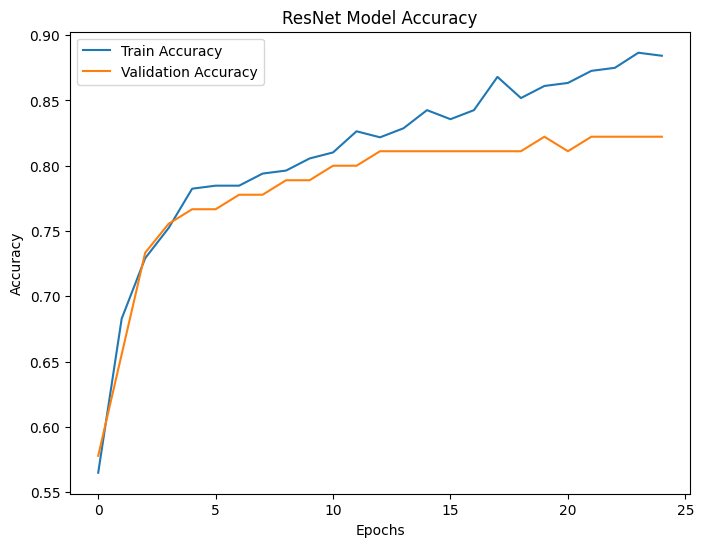

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

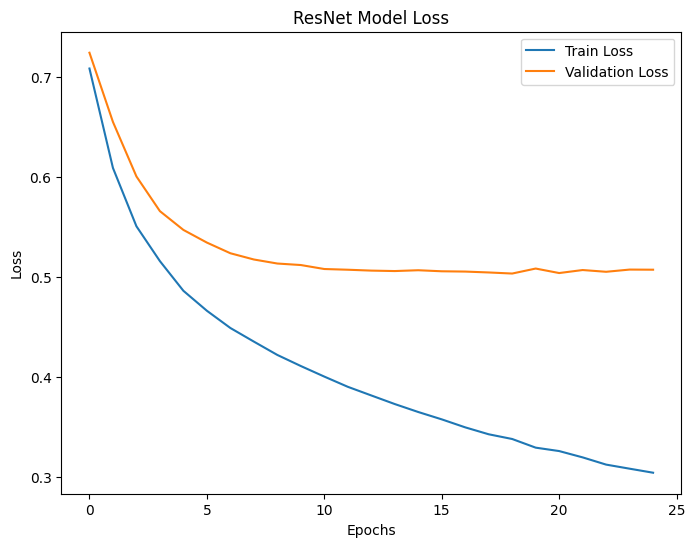

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = resnet_model.predict(x_test_aug)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.84        45
           1       0.89      0.73      0.80        45

    accuracy                           0.82        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.83      0.82      0.82        90



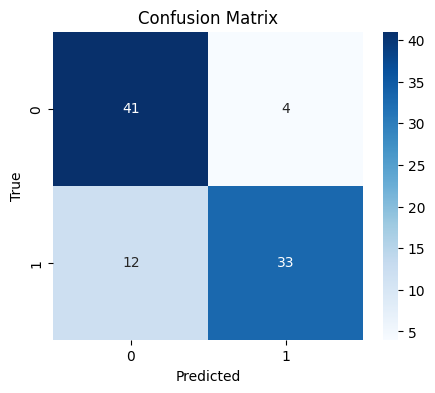

In [ ]:

cm = confusion_matrix(y_true_classes, y_pred_classes)
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model
resnet_model.save('parkinsons_resnet_model.h5')